In [ ]:
## Projekt zaliczeniowy

Link do submisji: wkrótce

Tymczasowy link do danych: https://drive.google.com/drive/folders/0BwExETCslterV0E1aXVObUlVUGs

### Opis projektu

Projekt polega na wytrenowaniu klasyfikatora kolorowych obrazków na datasecie [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html).

Zestaw danych wygląda następująco:
* X_train - zbiór treningowy - cechy (piksele, 3 kanały kolorów),
* y_train - etykiety X_train (0-9),
* X_train_small - losowy podzbiór X_train (10%),
* y_train_small - etykiety X_train_small,
* X_test - zbiór testowy, na którym należy obliczyć predykcje.

Tabelę y_test (etykiety zbioru testowego) można odnaleźć w internecie, ale proszę tego **nie** robić.

Pojedynczy wiersz tabelach X to wektor długości 3072, czterowymiarową macierz obrazków możemy uzyskać stosując metodę X.reshape(-1,3,32,32). Dane w tabelach X są intami - przed uczeniem należy je zrzutować na floaty. 

#### Część pierwsza - całość CIFAR-10

Dane, których można używać: X_train, y_train, X_test.

Model należy wytrenować na parze (X_train, y_train), a następnie przeliczyć i zasubmitować predykcje na X_test.

#### Część druga - subset CIFAR-10

Danie, których można używać: X_train, X_train_small, y_train_small, X_test.

**Nie** można używać tabeli y_train.


Model należy wytrenować unsupervised (pretraining / uczenie reprezentacji) na zbiorze X_train, a następnie kontynuować uczenie supervised na parze (X_train_small, y_train_small) i zasubmitować predykcję na X_test. Wynik trzeba porównać z wynikiem modelu nauczonego z pominięciem trenowania unsupervised.


### Punktacja

Liczba punktów za projekt podana jest w ogłoszeniach i różni się pomiędzy grupami ćwiczeniowymi.

Na rozwiązanie projektu składa się sześć jednakowo ocenianych części:

(CIFAR-10 - całość)
* opis przetestowanych modelów (w tym opcjonalnie preprocessing danych) - na czym w skrócie polega zasada ich działania, w jaki sposób są one w stanie dobrze klasyfikować obrazki,
* opis działania hiperparametrów, algorytm doboru hiperparametrów - za co odpowiadają poszczególne hiperparametry używanych modelów, jak dobrano najlepszy zestaw,
* przebicie 40% accuracy,
* przebicie 60% accuracy (hint: prosta sieć konwolucyjna),

(CIFAR-10 - subset)
* zastosowanie unsupervised pretrainingu na dużym zbiorze CIFAR-10, uczenie nadzorowane na subsecie - opis działania użytego pretrainingu, porównanie ze skutecznością takiego samego modelu, ale uczonego bez pretrainingu lub z pretrainingiem na zbiorze "subset",
* przebicie 50% accuracy.


Rozwiązania, w których najlepszy zestaw hiperparametrów został "odgadnięty", dobrany ręcznie itp. będą ocenione w całości na zero punktów.

Rozwiązania, w których podczas uczenia używano danych ze zbioru testowego będą ocenione w całości na zero punktów.

# Projekt

### importowanie bibliotek

In [1]:
import os
import time
import pickle
import random
import numpy as np
import pandas as pd
from scipy.misc import toimage
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline

from keras.datasets import cifar10
from keras.models import Sequential
from keras.models import Model
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import Input
from keras.layers import UpSampling2D
from keras.constraints import maxnorm
from keras.optimizers import SGD
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils
from keras import backend as K
#K.set_image_dim_ordering('th')
K.set_image_dim_ordering('tf')
np.random.seed(123)

Using TensorFlow backend.


### Funkcje do wczytywania i zapisu danych

In [2]:
def save_labels(arr, filename):
    pd_array = pd.DataFrame(arr)
    pd_array.index.names = ["Id"]
    pd_array.columns = ["Prediction"]
    pd_array.to_csv(filename)

def load_labels(filename):
    return pd.read_csv(filename, index_col=0).values.ravel()

def prepare_to_save(data):
    new_data = []
    for row in data:
        max_val_idx = next((idx for idx, val in np.ndenumerate(row) if val==max(row)))[0]
        new_data.append(max_val_idx+1)
    return new_data

def save_data(data, filename):
    new_data = prepare_to_save(data)
    save_labels(new_data, filename)
    
def save_model(model):
    with open("best_model.pkl", 'w') as f_out:
        pickle.dump(model, f_out)

# Część pierwsza

### Wczytywanie danych i preprocesing

In [3]:
# X_train = np.load("X_train.npy")
# y_train = load_labels("y_train.csv")
# X_test = np.load("X_test.npy")
# X_train = np.array([x.reshape((32, 32, 3))for x in X_train])
# X_test = np.array([x.reshape((32, 32, 3))for x in X_test])

In [4]:
# # normalizacja do przedziału 0.0-1.0
# X_train = X_train.astype('float32')
# X_train = X_train / 255.0
# X_test = X_test.astype('float32')
# X_test = X_test / 255.0

# # dane do random search
# sm_train_idx = list(range(len(X_train)))
# random.shuffle(sm_train_idx)
# ## train
# len_of_sm_train = 40000
# sm_train_idx = sm_train_idx[:len_of_sm_train]
# sm_X_train = X_train[sm_train_idx]
# sm_y_train = y_train[sm_train_idx]

# ## test
# len_of_sm_test = 10000
# sm_test_idx = sm_train_idx[-len_of_sm_test:]
# sm_X_test = X_train[sm_test_idx]
# sm_y_test = y_train[sm_test_idx]

# # przygotowanie danych do uczenia
# sm_y_train = np_utils.to_categorical(sm_y_train)
# sm_y_test = np_utils.to_categorical(sm_y_test)

# y_train = np_utils.to_categorical(y_train)
# num_classes = y_train.shape[1]
# print("Liczba klas:", num_classes)

# print("wyniary całego zbioru uczącego")
# print("train", X_train.shape, y_train.shape)
# print("test ", X_test.shape, "\n")

# print("wyniary małego zbioru uczącego")
# print("train", sm_X_train.shape, sm_y_train.shape)
# print("test ", sm_X_test.shape, sm_y_test.shape)

### Funkcje doboru hiperparametrów

Wzięte z notebook 6

Spośród czterech znanych mi metod doboru hiperparametrów wybrałem random_search ponieważ jest dużo lepszą metodą niż grid_search oraz random_gread_search a zarazem jest dużo prostszy w obsłudze i implementacji niż optymalizacja bayesowska.

In [5]:
# # rodzina rozkładów jednostajnych na podanych listach elementów
# # sampler losuje z rozkładu jednostajnego na liście l
# def uniform_from_list(l):
#     def sampler(rng):
#         return l[rng.randint(0,len(l))]
#     return sampler

# # rodzina rozkładów jednostajnych na przedziałach liczb całkowitych
# # sampler losuje z rozkładu jednostajnego na podzbiorze liczb całkowitych od low (włącznie) do high (wyłącznie)
# def uniform_int_on_interval(low, high):
#     def sampler(rng):
#         return rng.randint(low,high)
#     return sampler

# # rodzina rozkładów jednostajnych na przedziałach
# # sampler losuje z rozkładu jednostajnego na przedziale [low, high]
# def uniform_on_interval(low, high):
#     def sampler(rng):
#         return rng.uniform(low, high)
#     return sampler

# # rodzina rozkładów jednostajnych na przedziałach w wykładniku potęgi liczby 0.1
# # sampler losuje liczbę alpha z rozkładu jednostajnego na przedziale [low, high], a następnie zwraca 10^alpha
# def log_uniform_on_interval(low, high):
#     def sampler(rng):
#         return 0.1**rng.uniform(low, high)
#     return sampler

# # rodzina rozkładów gaussa
# # sampler losuje liczbę z rozkładu N(mean, std^2)
# def normal(mean, std):
#     def sampler(rng):
#         return rng.normal(loc=mean, scale=std)
#     return sampler

# # rodzina rozkładów gaussa w wykładniku potęgi liczby 10
# # sampler losuje liczbę alpha z rozkładu N(mean, std^2), a następnie zwraca 10^alpha
# def log_normal(mean, std):
#     def sampler(rng):
#         return 10**rng.normal(loc=mean, scale=std)
#     return sampler

# def random_search(grid, k=20, random_state=43):
#     rng = np.random.RandomState(random_state) # ustalamy jeden wspólny rng
#     (keys, samplers) = zip(*sorted(grid.items())) # sortujemy klucze, kolejność samplowania jest ważna!
#     # wysamplować k zestawów hiperparametrów
#     for _ in range(k):
#         elem = [samplers[i](rng) for i in range(len(samplers))]
#         yield dict(zip(keys, elem))

### Opis modelu

Do uczenia użyłem sieci konwolucyjnych ponieważ są one najskuteczniejszym znanym mi algorytmem do klasyfikacji obrazków. Przykładem zastosowania jest AlexNet[2].
Sieci konwolucyjne dzięki zastosowaniu filtrów, które są "przykładane" do poszczególnych fragmentów obrazków są wstanie nauczyć sie rozpoznawać podstawowe charakterystyczne cechy zdjęć, takie jak linie, a nstępnie, w kolejnych warstwach, dochodzić do uogólnień , które z prostych elementów składają coś bradziej skomplikowanego np. kwardrat, twarz. Sama zasada działania (od szczegółu do ogółu) narzuca możliwość zastosowania w klasyfikacji obrazów. W przypadku bardziej skomplikowanych sieci zaletą jest to, że przy zmianie rozpoznawanego zbioru nie trzeba od nowa uczyć początkowych warstw (w końcu większość obrazków składa się z kresek ustawionych pod róznym kontem).

#### Opis hiperprametrów
* 'lr' - określa jak duży krok robimy w metodzie gradientowej przy wyliczaniu nowych wag
* 'momentum' - zwiększa krok jeżeli acc mało się poprawia (przyspiesza na płaskich fragmentach przestrzeni wag).
* 'nesterov' - zmienna boolowska mówiąca czy ma działać algorytm  Nesterov momentum
* 'dropout_list' - lista z procentową liczbą neuronów, które zostaną usunięte, w poszczególnych warstwach sieci
* 'epochs' - liczba epok obliczeń
* 'batch_size' - wielkość batcha czyli ile zdjęć naraz jest przepuszczanych przez sieć
* 'decay' - określa jak bardzo zmniejszamy 'lr' w kolejnych epokach. Ustawiłem ten parametr na stałe 'lr'/'epoch' czyli liniowy spadek kroku.

#### Struktura sieci
Powinno się przetestować parę modeli sieci, ale niestety pojawia się tutaj problem czasu obliczeń. Aby przetestować parę modeli należałoby przeprowadzić dla każdego z nich wyszukiwanie hiperparametrów. Dlatego wszystkie testy przeprowadzone są tylko dla modelu_1, który jest dosyć prostą siecią konwolucyjną. Dla przykładu stworzyłem także bardziej rozbudowaną sieć, lecz ze względów czasowych nie byłem wstanie jej przetestwoać.
* model nr 1

* model nr 2

Oczywiście, aby być wpełni purystycznym należałoby przetestować różne funkcje aktywacji, różne liczby neuronów w warstwach, rozmiary konwolucji i rozmiary max poolingu. Tych parametrów jest dużo i, ze względu na ograniczenia sprzętu na którym pracuję, te rzeczy zostały zahardkodowane.

### Model

In [6]:
# class Model:
#     def __init__(self, dropout_list, model_nr=1, num_classes=10):
#         if model_nr==1:
#             self.model = Sequential()
#             self.model.add(Conv2D(32, (3, 3), input_shape=(32, 32, 3), padding='same', activation='relu', kernel_constraint=maxnorm(3)))
#             self.model.add(Dropout(dropout_list[0]))
#             self.model.add(Conv2D(32, (3, 3), activation='relu', padding='same', kernel_constraint=maxnorm(3)))
#             self.model.add(MaxPooling2D(pool_size=(2, 2)))
            
#             self.model.add(Flatten())
            
#             self.model.add(Dense(512, activation='relu', kernel_constraint=maxnorm(3)))
#             self.model.add(Dropout(dropout_list[1]))
#             self.model.add(Dense(num_classes, activation='softmax'))
        
#         elif model_nr==2:
#             self.model = Sequential()
#             self.model.add(Conv2D(32, (3, 3), input_shape=(3, 32, 32), activation='relu', padding='same'))
#             self.model.add(Dropout(dropout_list[0]))
#             self.model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
#             self.model.add(MaxPooling2D(pool_size=(2, 2)))
#             self.model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
#             self.model.add(Dropout(dropout_list[1]))
#             self.model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
#             self.model.add(MaxPooling2D(pool_size=(2, 2)))
            
#             self.model.add(Flatten())
            
#             self.model.add(Dropout(dropout_list[2]))
#             self.model.add(Dense(1024, activation='relu', kernel_constraint=maxnorm(3)))
#             self.model.add(Dropout(dropout_list[3]))
#             self.model.add(Dense(512, activation='relu', kernel_constraint=maxnorm(3)))
#             self.model.add(Dropout(dropout_list[4]))
#             self.model.add(Dense(num_classes, activation='softmax'))

#     def compile_model(self, lr=0.01, momentum=0.9, decay=0.001, metrics=['accuracy'], nesterov=False, write_info=False):
#         sgd = SGD(lr=lr, momentum=momentum, decay=decay, nesterov=nesterov)
#         self.model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=metrics)
#         if write_info:
#             print(self.model.summary())

#     def fit(self, X_train, y_train, X_test, y_test, epochs=10, batch_size=32, validation_data=True):
#         if validation_data:
#             self.model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size)
#             scores = self.model.evaluate(X_test, y_test, verbose=0)
#             print("Accuracy: %.2f%%" % (scores[1]*100))
#             return scores[1]
#         else:
#             self.model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size)
#             return None
        
        
#     def predict(self, X_test):
#         return self.model.predict(X_test)

In [7]:
# def run_model(X_train, y_train, X_test, y_test, params, model_nr=1, validation_data=True):
#     decay = params['lr']/params['epochs']
#     model = Model(params['dropout_list'], model_nr)
#     model.compile_model(lr=params['lr'], momentum=params['momentum'], decay=decay, nesterov=params['nesterov'])
#     score = model.fit(X_train, y_train, X_test, y_test, epochs=params['epochs'], validation_data=validation_data)
#     return model, score

### Doboru hiperparametrów

In [8]:
# model_nr = 1
# grid = {'lr': log_uniform_on_interval(0., 4.),
#         'epochs': uniform_from_list([3]), 
#         'momentum': uniform_on_interval(0, 1),
#         'nesterov': uniform_from_list([True, False]),
#         'dropout_list_1': uniform_on_interval(0., 0.5),
#         'dropout_list_2': uniform_on_interval(0., 0.5)}

# best_score = 0
# best_params = None
# idx = 1
# for params in random_search(k=100, random_state=43, grid=grid):
#     print("---------------------idx={}---------------------------".format(idx))
#     idx += 1
#     params['dropout_list'] = [params['dropout_list_1'], params['dropout_list_2']]
#     params.pop('dropout_list_1', None)
#     params.pop('dropout_list_2', None)
#     print(params)
#     start = time.time()
#     _, score = run_model(sm_X_train, sm_y_train, sm_X_test, sm_y_test, params, model_nr)
#     print("time:", time.time() - start)
#     if score > best_score:
#         best_score = score
#         best_params = params

#### Przykładowe rozwiązania
---------------------idx=1---------------------------<br />
{'lr': 0.29270904532646685, 'epochs': 3, 'momentum': 0.24058961996534878, 'nesterov': False, 'dropout_list': [0.05752728319488948, 0.3045332696397407]}
Accuracy: 29.46%
time: 554.4004256725311

---------------------idx=2---------------------------<br />
{'lr': 0.6603718605626717, 'epochs': 3, 'momentum': 0.6121321471707062, 'nesterov': False, 'dropout_list': [0.4055181959984358, 0.037370676793494095]}
Accuracy: 27.70%
time: 563.9104082584381

---------------------idx=3---------------------------<br />
{'lr': 0.0006191723092248898, 'epochs': 3, 'momentum': 0.2544211258598793, 'nesterov': True, 'dropout_list': [0.36687414814014147, 0.19747500921550293]}
Accuracy: 24.78%
time: 497.2196636199951

---------------------idx=4---------------------------<br />
{'lr': 0.0025183337710787982, 'epochs': 3, 'momentum': 0.5808772319264447, 'nesterov': True, 'dropout_list': [0.4773707682887041, 0.2778892674335427]}
Accuracy: 33.65%
time: 498.1103937625885

---------------------idx=5---------------------------<br />
{'lr': 0.0004020160656559383, 'epochs': 3, 'momentum': 0.971465091435388, 'nesterov': True, 'dropout_list': [0.03833134999822363, 0.4216123471148523]}
Accuracy: 44.93%
time: 511.5048818588257

---------------------idx=6---------------------------<br />
{'lr': 0.01924664448954633, 'epochs': 3, 'momentum': 0.13969232203438908, 'nesterov': True, 'dropout_list': [0.43688296882244987, 0.2775324003612934]}
Accuracy: 34.01%
time: 527.6232132911682

---------------------idx=7---------------------------<br />
{'lr': 0.0892854536590899, 'epochs': 3, 'momentum': 0.005129549064456951, 'nesterov': True, 'dropout_list': [0.44854928999076715, 0.14900175034438135]}
Accuracy: 34.34%
time: 530.2958166599274

---------------------idx=8---------------------------<br />
{'lr': 0.22355411549954554, 'epochs': 3, 'momentum': 0.3966942422737386, 'nesterov': False, 'dropout_list': [0.22241069181113077, 0.41238384185870613]}
Accuracy: 34.54%
time: 546.8627276420593

---------------------idx=9---------------------------<br />
{'lr': 0.3836402811408934, 'epochs': 3, 'momentum': 0.180914595257901, 'nesterov': True, 'dropout_list': [0.4550765378900783, 0.2626278355535727]}
Accuracy: 23.65%
time: 558.3954815864563

---------------------idx=10---------------------------<br />
{'lr': 0.0036644460749371485, 'epochs': 3, 'momentum': 0.26451339296091936, 'nesterov': False, 'dropout_list': [0.07672919113916521, 0.23646940613171874]}
Accuracy: 32.66%
time: 557.9403750896454

---------------------idx=11---------------------------<br />
{'lr': 0.1487423075122012, 'epochs': 3, 'momentum': 0.4044052430754076, 'nesterov': False, 'dropout_list': [0.13777938832447606, 0.4483736348704313]}
Accuracy: 36.34%
time: 534.1557807922363

---------------------idx=12---------------------------<br />
{'lr': 0.0038076397860102073, 'epochs': 3, 'momentum': 0.7760171399359068, 'nesterov': True, 'dropout_list': [0.26621693274277103, 0.15397828238107786]}
Accuracy: 41.30%
time: 533.4579668045044

---------------------idx=13---------------------------<br />
{'lr': 0.002086504574426105, 'epochs': 3, 'momentum': 0.7047156078805414, 'nesterov': False, 'dropout_list': [0.36349399598399423, 0.19959844295203738]}
Accuracy: 35.81%
time: 532.6273462772369

---------------------idx=14---------------------------<br />
{'lr': 0.0005669276455519518, 'epochs': 3, 'momentum': 0.8974241673628901, 'nesterov': False, 'dropout_list': [0.00018081270171127484, 0.41207962932468145]}
Accuracy: 37.51%
time: 556.4843828678131

---------------------idx=15---------------------------<br />
{'lr': 0.0633188322400611, 'epochs': 3, 'momentum': 0.14447837842282873, 'nesterov': False, 'dropout_list': [0.1451663888853783, 0.3279814139119269]}
Accuracy: 36.60%
time: 507.7975583076477

---------------------idx=16---------------------------<br />
{'lr': 0.0010477288487905838, 'epochs': 3, 'momentum': 0.4332223254840317, 'nesterov': False, 'dropout_list': [0.02628561969946891, 0.480357923520349]}
Accuracy: 31.56%
time: 518.5315270423889

---------------------idx=17---------------------------<br />
{'lr': 0.001655604248470483, 'epochs': 3, 'momentum': 0.10274277857321168, 'nesterov': True, 'dropout_list': [0.37388530589643154, 0.36007332392711144]}
Accuracy: 28.07%
time: 533.5988912582397

---------------------idx=18---------------------------<br />
{'lr': 0.29368127001627903, 'epochs': 3, 'momentum': 0.9155446186248152, 'nesterov': True, 'dropout_list': [0.37764936128012694, 0.46961162946996693]}
Accuracy: 10.01%
time: 506.23135447502136

---------------------idx=19---------------------------<br />
{'lr': 0.8004339487887737, 'epochs': 3, 'momentum': 0.4813033334553166, 'nesterov': False, 'dropout_list': [0.48270429083863164, 0.4993491229483435]}
Accuracy: 10.01%
time: 472.53144454956055

---------------------idx=20---------------------------<br />
{'lr': 0.0027668657064693477, 'epochs': 3, 'momentum': 0.9231056840067922, 'nesterov': False, 'dropout_list': [0.14782036119595376, 0.4532093762219861]}
Accuracy: 43.49%
time: 466.880996465683

---------------------idx=21---------------------------<br />
{'lr': 0.00015230777270992568, 'epochs': 3, 'momentum': 0.7398638198034742, 'nesterov': True, 'dropout_list': [0.43509073851729474, 0.4418007324869446]}
Accuracy: 24.50%
time: 478.4375088214874

---------------------idx=22---------------------------<br />
{'lr': 0.007671375365523788, 'epochs': 3, 'momentum': 0.28138746651495017, 'nesterov': False, 'dropout_list': [0.24719957796736924, 0.33356275366954313]}
Accuracy: 33.82%
time: 554.991147518158

---------------------idx=23---------------------------<br />
{'lr': 0.010953712949597677, 'epochs': 3, 'momentum': 0.044704402435746915, 'nesterov': False, 'dropout_list': [0.30846848791044756, 0.05167625543907722]}
Accuracy: 33.70%
time: 541.3227977752686

---------------------idx=24---------------------------<br />
{'lr': 0.0007594705326983841, 'epochs': 3, 'momentum': 0.38599949163865566, 'nesterov': True, 'dropout_list': [0.4565319744946051, 0.034940234256904845]}
Accuracy: 27.12%
time: 486.7026023864746

---------------------idx=25---------------------------<br />
{'lr': 0.006179358785951526, 'epochs': 3, 'momentum': 0.8448978875768562, 'nesterov': False, 'dropout_list': [0.1076142574935931, 0.4524855903166253]}
Accuracy: 42.11%
time: 482.84590554237366

---------------------idx=26---------------------------<br />
{'lr': 0.0021222061714955085, 'epochs': 3, 'momentum': 0.6086067291550195, 'nesterov': False, 'dropout_list': [0.3079551899021911, 0.22959293571933354]}
Accuracy: 34.49%
time: 481.0405225753784

---------------------idx=27---------------------------<br />
{'lr': 0.3068729679700206, 'epochs': 3, 'momentum': 0.6443704966138136, 'nesterov': False, 'dropout_list': [0.34707356787347543, 0.24234324480181324]}
Accuracy: 31.80%
time: 484.8254587650299

---------------------idx=28---------------------------<br />
{'lr': 0.011905652759448396, 'epochs': 3, 'momentum': 0.640455449629493, 'nesterov': False, 'dropout_list': [0.12095110768436312, 0.42317332366711347]}
Accuracy: 38.71%
time: 567.0722193717957

---------------------idx=29---------------------------<br />
{'lr': 0.02214409118231232, 'epochs': 3, 'momentum': 0.12075217051578746, 'nesterov': False, 'dropout_list': [0.4846277519155279, 0.3504878447166522]}
Accuracy: 31.89%
time: 598.4680247306824

---------------------idx=30---------------------------<br />
{'lr': 0.00019068992013405428, 'epochs': 3, 'momentum': 0.293963473917103, 'nesterov': True, 'dropout_list': [0.3884463858835834, 0.4496242325956038]}
Accuracy: 18.03%
time: 520.7719967365265

#### Najlepszy wynik:
{'lr': 0.0004020160656559383, 'epochs': 3, 'momentum': 0.971465091435388, 'nesterov': True, 'dropout_list': [0.03833134999822363, 0.4216123471148523]}<br />
Accuracy: 44.93%<br />
time: 511.5048818588257<br />

#### Wnioski:
a) Lepsze wyniki dla 'nesterov': True

b) Dla podobnego 'lr' lepsze wyniki są dla wyższego 'momentum'

c) 'lr' bliskie 1 ma bardzo złe wyniki

d) Jeżeli 'lr' jest bardzo małe to 'momentum' musi być duże

e) Nie zyskujemy dużo czasu dla wysokiego dropout

Spróbujmy zatem zobaczyć co się stanie dla bardzo małego 'lr', dużego 'momentun', 'nesterov' na True i 'dropout_list' równe [0.0, 0.0]

In [9]:
# params = {'lr': 0.0001, 'epochs': 3, 'momentum': 0.99, 'nesterov': True, 'dropout_list': [0., 0.]}
# print(params)
# start = time.time()
# _, score = run_model(sm_X_train, sm_y_train, sm_X_test, sm_y_test, params, model_nr)
# print("time:", time.time() - start)

{'lr': 0.0001, 'momentum': 1, 'nesterov': True, 'dropout_list': [0.0, 0.0], 'epochs': 3}<br />
Accuracy: 39.17%<br />
time: 492.173734664917

{'lr': 0.0001, 'momentum': 0.99, 'nesterov': True, 'dropout_list': [0.0, 0.0], 'epochs': 3}<br />
Accuracy: 43.99%<br />
time: 517.6123914718628<br />

Wyniki są wysokie ale słabsze od poprzednio znalezionego. Sprawdźmy zatem jak model z najlepszymi parametrami dla większej liczby epok.

In [10]:
best_params = {'lr': 0.0004020160656559383, 'epochs': 20, 'momentum': 0.971465091435388, 'nesterov': True, 'dropout_list': [0.03833134999822363, 0.4216123471148523]}
print("Najlepsze uzyskane parametry:")
print(best_params)

Najlepsze uzyskane parametry:
{'epochs': 20, 'dropout_list': [0.03833134999822363, 0.4216123471148523], 'nesterov': True, 'lr': 0.0004020160656559383, 'momentum': 0.971465091435388}


In [11]:
#model, score = run_model(sm_X_train, sm_y_train, sm_X_test, sm_y_test, best_params)

Train on 40000 samples, validate on 10000 samples<br />
Epoch 1/20<br />
40000/40000 [==============================] - 149s - loss: 2.0155 - acc: 0.2621 - val_loss: 1.8095 - val_acc: 0.3491<br />
Epoch 2/20<br />
40000/40000 [==============================] - 157s - loss: 1.7703 - acc: 0.3626 - val_loss: 1.6399 - val_acc: 0.4184<br />
Epoch 3/20<br />
40000/40000 [==============================] - 163s - loss: 1.6406 - acc: 0.4082 - val_loss: 1.5453 - val_acc: 0.4413<br />
Epoch 4/20<br />
40000/40000 [==============================] - 166s - loss: 1.5646 - acc: 0.4371 - val_loss: 1.4772 - val_acc: 0.4742<br />
Epoch 5/20<br />
40000/40000 [==============================] - 165s - loss: 1.5055 - acc: 0.4591 - val_loss: 1.4236 - val_acc: 0.4875<br />
Epoch 6/20<br />
40000/40000 [==============================] - 184s - loss: 1.4696 - acc: 0.4726 - val_loss: 1.4071 - val_acc: 0.4969<br />
Epoch 7/20<br />
40000/40000 [==============================] - 169s - loss: 1.4316 - acc: 0.4831 - val_loss: 1.3638 - val_acc: 0.5173<br />
Epoch 8/20<br />
40000/40000 [==============================] - 184s - loss: 1.4086 - acc: 0.4961 - val_loss: 1.3312 - val_acc: 0.5342<br />
Epoch 9/20<br />
40000/40000 [==============================] - 179s - loss: 1.3832 - acc: 0.5039 - val_loss: 1.2964 - val_acc: 0.5424<br />
Epoch 10/20<br />
40000/40000 [==============================] - 181s - loss: 1.3601 - acc: 0.5126 - val_loss: 1.2979 - val_acc: 0.5422<br />
Epoch 11/20<br />
40000/40000 [==============================] - 171s - loss: 1.3384 - acc: 0.5208 - val_loss: 1.2913 - val_acc: 0.5469<br />
Epoch 12/20<br />
40000/40000 [==============================] - 170s - loss: 1.3220 - acc: 0.5258 - val_loss: 1.2566 - val_acc: 0.5581<br />
Epoch 13/20<br />
40000/40000 [==============================] - 170s - loss: 1.3076 - acc: 0.5324 - val_loss: 1.2256 - val_acc: 0.5661<br />
Epoch 14/20<br />
40000/40000 [==============================] - 176s - loss: 1.2893 - acc: 0.5377 - val_loss: 1.2189 - val_acc: 0.5708<br />
Epoch 15/20<br />
40000/40000 [==============================] - 180s - loss: 1.2736 - acc: 0.5439 - val_loss: 1.1849 - val_acc: 0.5785<br />
Epoch 16/20<br />
40000/40000 [==============================] - 193s - loss: 1.2592 - acc: 0.5517 - val_loss: 1.1667 - val_acc: 0.5845<br />
Epoch 17/20<br />
40000/40000 [==============================] - 182s - loss: 1.2413 - acc: 0.5566 - val_loss: 1.1610 - val_acc: 0.5817<br />
Epoch 18/20<br />
40000/40000 [==============================] - 178s - loss: 1.2318 - acc: 0.5601 - val_loss: 1.1460 - val_acc: 0.5931<br />
Epoch 19/20<br />
40000/40000 [==============================] - 171s - loss: 1.2138 - acc: 0.5672 - val_loss: 1.1357 - val_acc: 0.5973<br />
Epoch 20/20<br />
40000/40000 [==============================] - 170s - loss: 1.2074 - acc: 0.5686 - val_loss: 1.1172 - val_acc: 0.6032<br />

Uwaga: te obliczenia zostały uruchomione na danych losowo wybranych ze zbioru uczącego i sa inne niż przy doborze hiperparametrów. Niestety nie mam kodu potwierdzającego taki stan rzeczy, ale wynik po 3 epoce jest inny niż w przypadku doboru hiperparametrów.

#### Wnioski
Ten prosty model osiągnął stosunkowo wysoką skuteczność na danych treningowych przy małej ilości epok i prawdopodobnie całkiem dobrze powinien poradzić sobie z danymi testowymi. Należy więc teraz nauczyć model na wszystkich dostępnych danych i na większej liczbie epok.

### Nauka najlepszego modelu 

In [12]:
# best_params['epochs'] = 80
# model, score = run_model(X_train, y_train, None, None, best_params, validation_data=False)
# data_to_save = model.predict(X_test)
# save_data(data_to_save, "y_pred.csv")

#### Przebieg uczenia najlepszego modelu

#### Wnioski

* model pomimo swojej prostoty powinien osiągać całkiem dobre wyniki
* pomimo 80 epok sieć nadal dość szybko uczy się dopasowywać do danych (~0.5% na eopkę)
* prosta sieć konwolucyjna z dobrze dobranymi hiperparametrami potrafi bardzo szybko nauczyć się takich danych

# Część druga

### Wczytywanie danych i preprocesing

In [23]:
X_train = np.load("X_train.npy")
X_train = np.array([x.reshape((3, 32, 32))for x in X_train])
X_train = X_train.transpose([0,2,3,1])
X_train = X_train.astype('float32')
X_train = X_train / 255.0

X_test = np.load("X_test.npy")
X_test = np.array([x.reshape((3, 32, 32))for x in X_test])
X_test = X_test.transpose([0,2,3,1])
X_test = X_test.astype('float32')
X_test = X_test / 255.0

X_train_small = np.load("X_train_small.npy")
X_train_small = np.array([x.reshape((3, 32, 32))for x in X_train_small])
X_train_small = X_train_small.transpose([0,2,3,1])
X_train_small = X_train_small.astype('float32')
X_train_small = X_train_small / 255.0

y_train_small = load_labels("y_train_small.csv")
y_train_small = np_utils.to_categorical(y_train_small)

In [14]:
num_classes = 10
print("Liczba klas:", num_classes)

print("wyniary zbioru unsupervised")
print("train", X_train.shape)
print()
print("wyniary małego zbioru uczącego")
print("train", X_train_small.shape, y_train_small.shape)

Liczba klas: 10
wyniary zbioru unsupervised
train (50000, 32, 32, 3)

wyniary małego zbioru uczącego
train (5000, 32, 32, 3) (5000, 10)


Moja wiedza mówi mi, że aby zastosować uczenie unsupervised [6-9] należy użyć autoenkoderów. Istnieją dwa podejścia do tematu:
* uczyc cały autoenkoder naraz
* nauczyć jednowarstwowy autoenkoder, wziąć z niego enkoder, zamrozić jego wagi i dokleić kolejną warstwę sieci i znowu stworzyć autoenkoder tym razem dwó warstwowy itd...

Ja wybrałem pierwsze podejście.

No to do działa!

### Opis autoencoder

### Opis modelu

### Tworzenie autoenkodera i modelu

In [15]:
# def create_autoencoder(input_img):
#     x = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_constraint=maxnorm(3))(input_img)
#     x = MaxPooling2D(pool_size=(2, 2), padding='same')(x)
#     x = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_constraint=maxnorm(3))(x)
#     encoded = MaxPooling2D((2, 2), padding='same')(x)

#     x = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_constraint=maxnorm(3))(encoded)
#     x = UpSampling2D((2, 2))(x)
#     x = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_constraint=maxnorm(3))(x)
#     x = UpSampling2D((2, 2))(x)
#     decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

#     autoencoder = Model(input_img, decoded)
#     autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
    
#     return autoencoder

# def upgrage_encoded(autoencoder, dropout, input_img, lr=0.0004020160656559383, momentum=0.971465091435388, decay=None, metrics=['accuracy'], nesterov=True, epochs=20):
#     if decay is None:
#         decay = lr/epochs

#     x = autoencoder.layers[-6].output
#     x = Flatten()(x)
#     x = Dense(512, activation='relu', kernel_constraint=maxnorm(3))(x)
#     x = Dropout(dropout)(x)
#     x = Dense(10, activation='softmax')(x)
    
#     model = Model(input_img, x)
#     sgd = SGD(lr=lr, momentum=momentum, decay=decay, nesterov=nesterov)
#     model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=metrics)
    
#     return model

In [16]:
# input_img = Input(shape=X_train.shape[1:])
# autoencoder = create_autoencoder(input_img)

### Uczenie autoenkodera

In [51]:
# autoencoder.fit(X_train, X_train, epochs=15, batch_size=32, validation_data=(X_train_small, X_train_small))

#### Przebieg uczenia

#### Zobaczmy jak działa autoenkoder

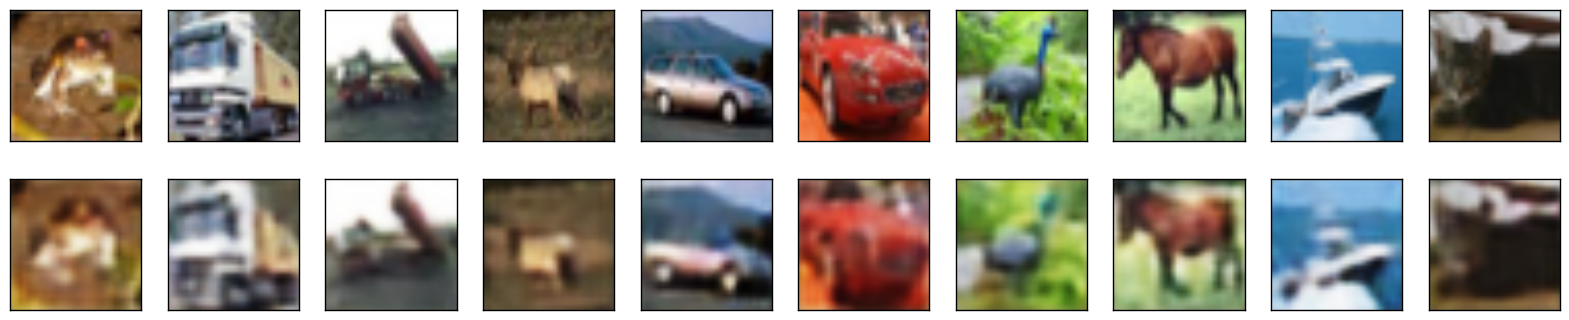

In [18]:
decoded_imgs = autoencoder.predict(X_train)
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i+1)
    plt.imshow(X_train[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n+1)
    plt.imshow(decoded_imgs[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

### Wnioski

* Więcej niż okolo 10 epok wiele nie daje
* loss i val_loss zminiają się bardzo wolno

### Uczenie modelu

In [44]:
# dropout = 0.4216123471148523
# epochs = 30
# model = upgrage_encoded(autoencoder, dropout, input_img, epochs=epochs, decay=0.00001)

In [52]:
# model.fit(X_train_small, y_train_small, epochs=epochs, batch_size=32)

#### Przebieg uczenia

In [37]:
# data_to_save = model.predict(X_test)
# save_data(data_to_save, "y_pred_2.csv")

#### Ten sam model, ale bez pretrainingu

In [46]:
# input_img = Input(shape=X_train.shape[1:])
# autoencoder2 = create_autoencoder(input_img)
# model2 = upgrage_encoded(autoencoder2, dropout, input_img, epochs=epochs, decay=0.00001)

In [53]:
# model2.fit(X_train_small, y_train_small, epochs=epochs, batch_size=32)

#### Przebieg uczenia

### Wnioski
#### Porównanie modelu z części pierwszej z modelem z części drugiej
* Model wykorzystany w pierwzej i drugiej części projektu jest podobny.
* Model z pierwszej częsci uczył się ponad 1.5 razy dłużej
* W drugiej części projektu w uczeniu autoenkodera loss prawie się nie zminiał za to w uczeniu końcowego modelu malał on dużo szybciej niż w modelu pierwszym
* Model drugi dużo szybciej dopasował się do testu trenującego. Zbiór był 10 razy mniejszy, ale wciąż tempo jest dużo szybsze - widać wpływ wcześniejszego uczenia wag w autoenkoderze
* Dzięki zastosowaniu autoenkodera model ma mniejszą szansę na przeucznie

#### Porównie modeli z części drugiej
* Od początku uczenia model bez pretrainingu ma dużo niższe acc i uczy się wolniej
* Czas uczenia model bez pretreningu jest dużo mniejszy (aby osiągnąć acc 66% potrzeba było około 10 razy mniej czasu, choć zapewne dobicie do acc 98% nie było by tak łatwe)
* Model bez pretreningu na tak małym zbiorze ma dużą szansę na przeuczenie się
* Prawie zawsze lepiej jest wykorzystać więcej danych niż mniej (czyli pretrening jest lepszy)
* Wydaje się jednak, że pre-training nie jest już tak popularną metodą jak parę lat temu [7] choć nie za bardzo rozumim dlaczego. Czasami etykietowanie danych może być bardzo kosztowne (np. dane medyczne, wojenne) i wydaje mi się, że wtakich sytuacjach metoda ta może podbić nam parę procent skuteczności.

### Bibliografia

[1] https://stats.stackexchange.com/questions/179915/whats-the-difference-between-momentum-based-gradient-descent-and-nesterovs-ac

[2] Krizhevsky, A., Sutskever, I., & Hinton, G. E. (2012). Imagenet classification with deep convolutional neural networks. In Advances in neural information processing systems (pp. 1097-1105).

[3] https://keras.io/

[4] https://stats.stackexchange.com/questions/95495/guideline-to-select-the-hyperparameters-in-deep-learning

[5] https://roamanalytics.com/2016/09/15/optimizing-the-hyperparameter-of-which-hyperparameter-optimizer-to-use/

[6] https://www.youtube.com/watch?v=Oq38pINmddk

[7] https://stackoverflow.com/questions/37259515/why-pretraining-for-dnn-is-not-specified-in-keras

[8] https://stats.stackexchange.com/questions/163600/pre-training-in-deep-convolutional-neural-network

[9] https://github.com/fchollet/keras/issues/358